# Data Conversion to HDF5 Format : Lithostratigraphic Chart Vs ALL

Author:Adnan Latif, adnanl@ifi.uio.no

1. Prerequests 
    - Copy all files in on folder, convert png or TIF to JPEG, assign unique identifire as prefix to each class

2. List images and their labels
    - List all images, give them proper labels, and then shuffle the data. 
    - Lithostrigrphic chart a label = 0 and each rest of the iamage a label = 1. 
    - Split data into train (%60), validation (%20), and test parts (%20)

In [1]:
from random import shuffle
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import glob
import h5py
import cv2

In [2]:
shuffle_data = True                                         # Shuffle the addresses before saving
hdf5_path = 'AllGeoImages/dataset_for_lithochart_vs_all_Other_Classes_V0.hdf5'  # Address to where to save the hdf5 file
litho_vs_other_train_path = 'AllGeoImages/*.jpeg'

                                                            # Read addresses and labels from the 'AllGeoImages' folder
addrs = glob.glob(litho_vs_other_train_path)
labels = [0 if 'litho_' in addr else 1 for addr in addrs]   # 0= Lithostratigraphic Chart, 1 = Others

# Shuffle data
if shuffle_data:
        c = list(zip(addrs, labels))
        shuffle(c)
        addrs, labels = zip(*c)
    
                                                            # Divide data into 60% train, 20% validation, and 20% test
train_addrs = addrs[0:int(0.8*len(addrs))] # 0.6 for 60% train, 20% validation, and 20% test
train_labels = labels[0:int(0.8*len(labels))]

#val_addrs = addrs[int(0.6*len(addrs)):int(0.8*len(addrs))]
#val_labels = labels[int(0.6*len(addrs)):int(0.8*len(addrs))]

test_addrs = addrs[int(0.8*len(addrs)):]
test_labels = labels[int(0.8*len(labels)):]



In [3]:
print (test_labels) # Label number 8 is O, shuffled data, only have 0 and 1
print (test_addrs) 


(1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1)
('AllGeoImages/paleomap_Paleogeographic maps Western Canada Foreland Basin 8.jpeg', 'AllGeoImages/geomapwithprop_4.Depth of the Dunlin Gp.jpeg', 'AllGeoImages/geomapwithprop_42.Top of Utsira Formation.jpeg', 'AllGeoImages/geomapwithprop_Thickness map of Quaternary in the Barents Sea.jpeg', 'AllGeoImages/geomap_10.Structure and Geological mape.jpeg', 'AllGeoImages/geomapwithprop_39.Modelling of CO2 injection and migration in the Stord basin.jpeg', 'AllGeoImages/geomapwithprop_5.Thickness of the Cook Fm.jpeg', 'AllGeoImages/litho_LithoChart_8.Carpentaria Basin.jpeg', 'AllGeoImages/geomapwithprop_3.Net to Gross Nordmela Formation.jpeg', 'AllGeoImages/litho_LithoChart_7.Money Shoal Basin Stratigraphic Correlation Chart.jpeg', 'AllGeoImages/paleomap_Kaskaskia IV -Middle - Early Carboniferous.jpeg', 'AllGeoImages/litho_Lit

3. Create a HDF5 file (h5py only, not Tables)

    Create a HDF5 file
    - To store images,define an array for each of train, validation and test sets with the shape of (number of data, image_height, image_width, image_depth) in Tensorflow order or (number of data,image_width, image_depth,image_height) in Theano order. 
    - For labels, define array for each of train, validation and test sets with the shape of (number of data). 
    - calculate the pixel-wise mean of the train set and save it in an array with the shape of (1, image_height, image_width, image_depth)

In [4]:
data_order = 'tf'                             # 'th' for Theano, 'tf' for Tensorflow (diffrent order of data)

if data_order == 'th':
    train_shape = (len(train_addrs), 3, 64, 64) # previously was 224
    #val_shape = (len(val_addrs), 3, 64, 64) # if have valudataion set
    test_shape = (len(test_addrs), 3, 64, 64)
elif data_order == 'tf':
    train_shape = (len(train_addrs), 64, 64, 3)
    #val_shape = (len(val_addrs), 64, 64, 3) # if have valudataion set
    test_shape = (len(test_addrs), 64, 64, 3)
    
                                                # open a hdf5 file and create earrays
hdf5_file = h5py.File(hdf5_path, mode='w')
hdf5_file.create_dataset("train_img", train_shape, np.int8)
#hdf5_file.create_dataset("val_img", val_shape, np.int8)                # if have valudataion set
hdf5_file.create_dataset("test_img", test_shape, np.int8)
hdf5_file.create_dataset("train_mean", train_shape[1:], np.float32)
hdf5_file.create_dataset("train_labels", (len(train_addrs),), np.int8)
hdf5_file["train_labels"][...] = train_labels
# hdf5_file.create_dataset("val_labels", (len(val_addrs),), np.int8)
#hdf5_file["val_labels"][...] = val_labels                                # if have valudataion set
hdf5_file.create_dataset("test_labels", (len(test_addrs),), np.int8)
hdf5_file["test_labels"][...] = test_labels

4. PREPROCESSING (only resize to 64 , 64) # priviously was 224

In [5]:
                                                        # 1. A numpy array to save the mean of the images
mean = np.zeros(train_shape[1:], np.float32)
                                                        # 2. loop over train addresses
for i in range(len(train_addrs)):
                                                        # read an image and resize to (64, 64)
                                                        # cv2 load images as BGR, convert it to RGB
    addr = train_addrs[i]
    img = cv2.imread(addr)
    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                                                        # any additional image pre-processing here
                                                        # if the data order is Theano, axis orders should change
    if data_order == 'th':
        img = np.rollaxis(img, 2)
                                                        # save the image and calculate the mean so far
    hdf5_file["train_img"][i, ...] = img[None]
    mean += img / float(len(train_labels))
                                                        # loop over validation addresses
#for i in range(len(val_addrs)):
    
                                                        # read an image and resize to (64, 64)
                                                        # cv2 load images as BGR, convert it to RGB
   # addr = val_addrs[i]
   # img = cv2.imread(addr)
    #img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
   # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                                                        # any additional image pre-processing here
                                                        # if the data order is Theano, axis orders should change
   # if data_order == 'th':
        #img = np.rollaxis(img, 2)
                                                        # save the image
    #hdf5_file["val_img"][i, ...] = img[None]
                                                        # loop over test addresses
for i in range(len(test_addrs)):
    
                                                        # read an image and resize to (64, 64)
                                                        # cv2 load images as BGR, convert it to RGB
    addr = test_addrs[i]
    img = cv2.imread(addr)
    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                                                        # add any image pre-processing here
                                                        # if the data order is Theano, axis orders should change
    if data_order == 'th':
        img = np.rollaxis(img, 2)
                                                        # save the image
    hdf5_file["test_img"][i, ...] = img[None]
                                                        # save the mean and close the hdf5 file
hdf5_file["train_mean"][...] = mean
hdf5_file.close()

5. Read the HDF5 file

    Check if the data is saved properly in the HDF5 file
    - Load the data in batchs of an arbitrary size and plot the first image of the first 5 batchs
    - Check the label of each image
 

1 / 15
1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


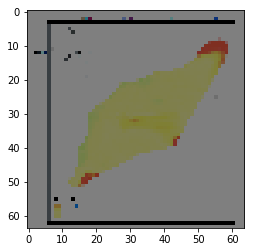

2 / 15
1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


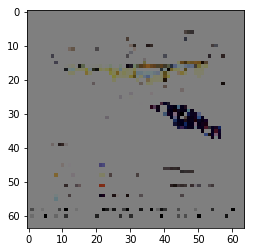

3 / 15
1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


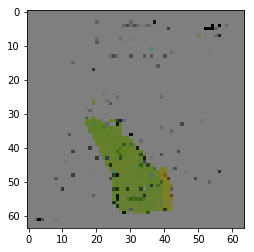

4 / 15
1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


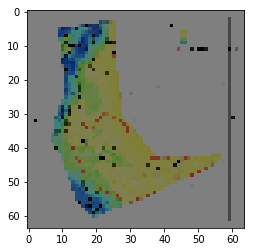

5 / 15
1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


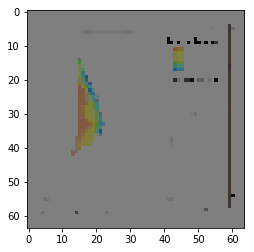

6 / 15
0 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


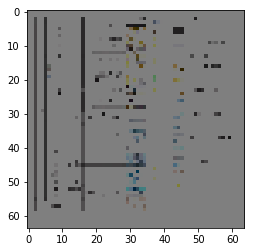

In [6]:
subtract_mean = False
                                                        # open the hdf5 file
hdf5_file = h5py.File(hdf5_path, "r")
                                                        # subtract the training mean
if subtract_mean:
    mm = hdf5_file["train_mean"][0, ...]
    mm = mm[np.newaxis, ...]
                                                        # Total number of samples
data_num = hdf5_file["train_img"].shape[0]
batch_size = 16                                         # select batch size, 32, 64 ....

                                                        # create list of batches to shuffle the data
batches_list = list(range(int(ceil(float(data_num) / batch_size))))
shuffle(batches_list)
                                                        # loop over batches
for n, i in enumerate(batches_list):
    i_s = i * batch_size                                # index of the first image in this batch
    i_e = min([(i + 1) * batch_size, data_num])         # index of the last image in this batch
                                                        # read batch images and remove training mean
    images = hdf5_file["train_img"][i_s:i_e, ...]
    if subtract_mean:
        images -= mm
    
                                                        # read labels and convert to one hot encoding
    labels = hdf5_file["train_labels"][i_s:i_e]
    labels_one_hot = np.zeros(batch_size, np.float32)
    labels_one_hot[np.arange(batch_size)] = 1
    print (n+1, '/', len(batches_list))
    print (labels[0], labels_one_hot[:])
    plt.imshow(images[0])
    plt.show()
    if n == 5:                                           # break after 5 batches
        break
hdf5_file.close()